<a href="https://colab.research.google.com/github/EsserMishelle/short-term-stock-forecast/blob/main/01_eda_and_naive_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective
The objective of this project is to forecast the short-term closing price of NVIDIA (NVDA) stock using classical time-series models and compare their performance using information criteria and forecast accuracy.

## Define the prediction task

This project focuses on classical time-series forecasting methods demonstrated in class, comparing ARIMA, Prophet, and linear trend models using AIC and forecast error metrics.

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from xgboost import XGBRegressor

import xgboost as xgb


from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

import seaborn as sns
import os
import time

### Download from Yahoo Finance

In [2]:
TICKERS = ['NVDA', 'AMD', 'TSM','QQQ', '^VIX', '^TNX']
START_DATE = '2021-01-01'
END_DATE = '2026-02-05'

stocks = yf.download(
    TICKERS,
    start=START_DATE,
    end=END_DATE,
    group_by='ticker',
    auto_adjust=True,
    prepost=True,
    threads=True,
    progress=False
)
stocks.head(3)


Ticker             QQQ                                                \
Price             Open        High         Low       Close    Volume   
Date                                                                   
2021-01-04  305.791619  305.966318  296.155274  300.163147  45305900   
2021-01-05  299.173320  302.909474  299.173320  302.637726  29323400   
2021-01-06  297.921517  302.657212  296.931691  298.445557  52809600   

Ticker           NVDA                                              ...  \
Price            Open       High        Low      Close     Volume  ...   
Date                                                               ...   
2021-01-04  13.067502  13.614215  12.926149  13.076726  560640000  ...   
2021-01-05  13.063014  13.405800  13.050300  13.367159  322760000  ...   
2021-01-06  13.185418  13.207855  12.550704  12.579123  580424000  ...   

Ticker           ^VIX                                                 TSM  \
Price            Open       High        Low      Close Volume        Open   
Date                                                                        
2021-01-04  23.040001  29.190001  22.559999  26.969999      0  102.502923   
2021-01-05  26.940001  28.600000  24.799999  25.340000      0  103.367285   
2021-01-06  25.480000  26.770000  22.139999  25.070000      0  104.691455   

Ticker                                                    
Price             High         Low       Close    Volume  
Date                                                      
2021-01-04  104.921353  101.564971  102.714417  11262100  
2021-01-05  105.702951  102.999461  103.698318  10583600  
2021-01-06  107.027128  103.496036  106.309875  10609300  

[3 rows x 30 columns]

In [3]:
display(stocks.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1278 entries, 2021-01-04 to 2026-02-04
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (QQQ, Open)     1278 non-null   float64
 1   (QQQ, High)     1278 non-null   float64
 2   (QQQ, Low)      1278 non-null   float64
 3   (QQQ, Close)    1278 non-null   float64
 4   (QQQ, Volume)   1278 non-null   int64  
 5   (NVDA, Open)    1278 non-null   float64
 6   (NVDA, High)    1278 non-null   float64
 7   (NVDA, Low)     1278 non-null   float64
 8   (NVDA, Close)   1278 non-null   float64
 9   (NVDA, Volume)  1278 non-null   int64  
 10  (AMD, Open)     1278 non-null   float64
 11  (AMD, High)     1278 non-null   float64
 12  (AMD, Low)      1278 non-null   float64
 13  (AMD, Close)    1278 non-null   float64
 14  (AMD, Volume)   1278 non-null   int64  
 15  (^TNX, Open)    1278 non-null   float64
 16  (^TNX, High)    1278 non-null   float64
 17  (^TNX, Low)    

None

#### The raw dataframe file has 30 columns and 1278 rows

### Save the main file, and divide it by price and volume and save them in 2 other files

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Flatten columns for easier use later

stocks_flat = stocks.copy()

stocks_flat.columns = ['_'.join(col) for col in stocks_flat.columns.values]
stocks_flat.head()

,QQQ_Open,QQQ_High,QQQ_Low,QQQ_Close,QQQ_Volume,NVDA_Open,NVDA_High,NVDA_Low,NVDA_Close,NVDA_Volume,...,^VIX_Open,^VIX_High,^VIX_Low,^VIX_Close,^VIX_Volume,TSM_Open,TSM_High,TSM_Low,TSM_Close,TSM_Volume
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,305.791619,305.966318,296.155274,300.163147,45305900,13.067502,13.614215,12.926149,13.076726,560640000,...,23.040001,29.190001,22.559999,26.969999,0,102.502923,104.921353,101.564971,102.714417,11262100
2021-01-05,299.173320,302.909474,299.173320,302.637726,29323400,13.063014,13.405800,13.050300,13.367159,322760000,...,26.940001,28.600000,24.799999,25.340000,0,103.367285,105.702951,102.999461,103.698318,10583600
2021-01-06,297.921517,302.657212,296.931691,298.445557,52809600,13.185418,13.207855,12.550704,12.579123,580424000,...,25.480000,26.770000,22.139999,25.070000,0,104.691455,107.027128,103.496036,106.309875,10609300
2021-01-07,301.104442,306.500020,301.075331,305.665466,30394800,12.931135,13.340235,12.850363,13.306580,461480000,...,23.670000,23.910000,22.250000,22.370001,0,109.739829,113.050237,108.130606,111.661705,13556100
2021-01-08,307.955677,309.945073,305.762500,309.595703,33955800,13.325026,13.383362,13.005425,13.239516,292528000,...,22.430000,23.340000,21.420000,21.559999,0,115.781317,116.130746,107.569680,109.142120,18976800


In [6]:
# Since ^VTX and ^TNX are an index and yield series and not traded security, they do not have trading volume (Volume column is 0)
# We will use 'Close' only and drop these columns

cols_to_drop = ['^VIX_Volume', '^TNX_Volume']
stocks_flat_clean = stocks_flat.drop(columns=cols_to_drop)

stocks_flat_clean.to_csv(
    '/content/drive/MyDrive/stocks/stocks_raw_2021_2026_clean.csv',
    index=True
)

print("Saved: stock_raw_2021_2026_clean.csv")

Saved: stock_raw_2021_2026_clean.csv


In [7]:
stocks_flat_clean.columns

Index(['QQQ_Open', 'QQQ_High', 'QQQ_Low', 'QQQ_Close', 'QQQ_Volume',
       'NVDA_Open', 'NVDA_High', 'NVDA_Low', 'NVDA_Close', 'NVDA_Volume',
       'AMD_Open', 'AMD_High', 'AMD_Low', 'AMD_Close', 'AMD_Volume',
       '^TNX_Open', '^TNX_High', '^TNX_Low', '^TNX_Close', '^VIX_Open',
       '^VIX_High', '^VIX_Low', '^VIX_Close', 'TSM_Open', 'TSM_High',
       'TSM_Low', 'TSM_Close', 'TSM_Volume'],
      dtype='object')

In [8]:
# Select only closing price-related columns
price_cols = [c for c in stocks_flat_clean.columns if 'Close' in c or 'Adj Close' in c]
price_df = stocks_flat_clean[price_cols]

price_df.to_csv(
    '/content/drive/MyDrive/stocks/stock_price_2021_2026.csv',
    index=True
)
print("- stock_price_2021_2026.csv")
price_df.head()

- stock_price_2021_2026.csv


,QQQ_Close,NVDA_Close,AMD_Close,^TNX_Close,^VIX_Close,TSM_Close
Date,,,,,,
2021-01-04,300.163147,13.076726,92.300003,0.917,26.969999,102.714417
2021-01-05,302.637726,13.367159,92.769997,0.955,25.340000,103.698318
2021-01-06,298.445557,12.579123,90.330002,1.042,25.070000,106.309875
2021-01-07,305.665466,13.306580,95.160004,1.071,22.370001,111.661705
2021-01-08,309.595703,13.239516,94.580002,1.105,21.559999,109.142120


In [9]:
# Select only volume-related columns
volume_cols = [c for c in stocks_flat_clean.columns if 'Volume' in c]
volume_df = stocks_flat_clean[volume_cols]

volume_df.to_csv(
    '/content/drive/MyDrive/stocks/stock_volume_2021_2026.csv',
    index=True
)
print("- stock_volume_2021_2026.csv")
volume_df.head()


- stock_volume_2021_2026.csv


,QQQ_Volume,NVDA_Volume,AMD_Volume,TSM_Volume
Date,,,,
2021-01-04,45305900,560640000,51802600,11262100
2021-01-05,29323400,322760000,34208000,10583600
2021-01-06,52809600,580424000,51911700,10609300
2021-01-07,30394800,461480000,42897200,13556100
2021-01-08,33955800,292528000,39816400,18976800


### Load NVDA price and volume and merge them together

In [10]:
import pandas as pd

# --- Load the two FILES ---
price_df = pd.read_csv(
    '/content/drive/MyDrive/stocks/stock_price_2021_2026.csv',
    index_col='Date',
    parse_dates=True
)
price_df.columns = price_df.columns.str.lower()

volume_df = pd.read_csv(
    '/content/drive/MyDrive/stocks/stock_volume_2021_2026.csv',
    index_col='Date',
    parse_dates=True
)
volume_df.columns = volume_df.columns.str.lower()

# Keep only NVDA for now
p = price_df[[('nvda_close')]].copy()
v = volume_df[[('nvda_volume')]].copy()

# # Rename column names
p.columns = ['nvda_close']
v.columns = ['nvda_volume']


# Merge price + volume by date
df = p.join(v, how='inner')

display(df.info())
print()

display(df.describe())
print()

display(df.head())
print()
display(df.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1278 entries, 2021-01-04 to 2026-02-04
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   nvda_close   1278 non-null   float64
 1   nvda_volume  1278 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 30.0 KB


None

,nvda_close,nvda_volume
count,1278.000000,1.278000e+03
mean,69.329726,3.907986e+08
std,59.103824,1.843901e+08
min,11.212904,6.552850e+07
25%,19.515135,2.365302e+08
50%,42.327452,3.756440e+08
75%,121.585546,5.028558e+08
max,207.028473,1.543911e+09


,nvda_close,nvda_volume
Date,,
2021-01-04,13.076726,560640000
2021-01-05,13.367159,322760000
2021-01-06,12.579123,580424000
2021-01-07,13.306580,461480000
2021-01-08,13.239516,292528000


,nvda_close,nvda_volume
Date,,
2026-01-29,192.509995,171764400
2026-01-30,191.130005,179489500
2026-02-02,185.610001,165794100
2026-02-03,180.339996,204019600
2026-02-04,174.190002,207014100


In [11]:
print(price_df.columns)
print(volume_df.columns)

Index(['qqq_close', 'nvda_close', 'amd_close', '^tnx_close', '^vix_close',
       'tsm_close'],
      dtype='object')
Index(['qqq_volume', 'nvda_volume', 'amd_volume', 'tsm_volume'], dtype='object')


#### The time frame of the dataset is: 2021-01-04 to 2026-02-04.  There are 2 columns, 1278 rows and no null values.

In [12]:
# # Divide the stocks DataFrame by TICKER and duplicate it.
nvda = price_df[['nvda_close']].copy()
amd = price_df[['amd_close']].copy()
tsm = price_df[['tsm_close']].copy()
qqq = price_df[['qqq_close']].copy()

# All indices are sorted chronologically to preserve temporal order.
nvda = nvda.sort_index()
amd = amd.sort_index()
tsm = tsm.sort_index()
qqq = qqq.sort_index()

## Divide the volume by Ticker
nvda_volume = volume_df[['nvda_volume']].copy()
amd_volume = volume_df[['amd_volume']].copy()
tsm_volume = volume_df[['tsm_volume']].copy()
qqq_volume = volume_df[['qqq_volume']].copy()

# All indices are sorted chronologically to preserve temporal order.
nvda_volume = nvda_volume.sort_index()
amd_volume = amd_volume.sort_index()
tsm_volume = tsm_volume.sort_index()
qqq_volume = qqq_volume.sort_index()



In [13]:
display(nvda.head(2))
display(nvda.tail(2))

,nvda_close
Date,
2021-01-04,13.076726
2021-01-05,13.367159


,nvda_close
Date,
2026-02-03,180.339996
2026-02-04,174.190002


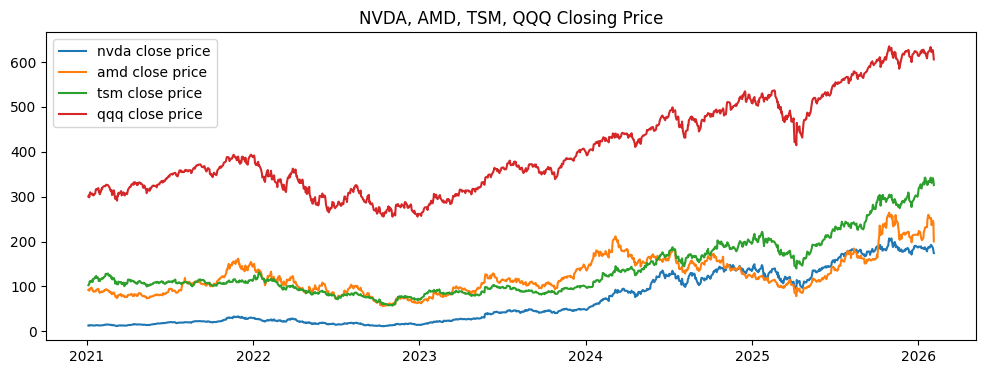

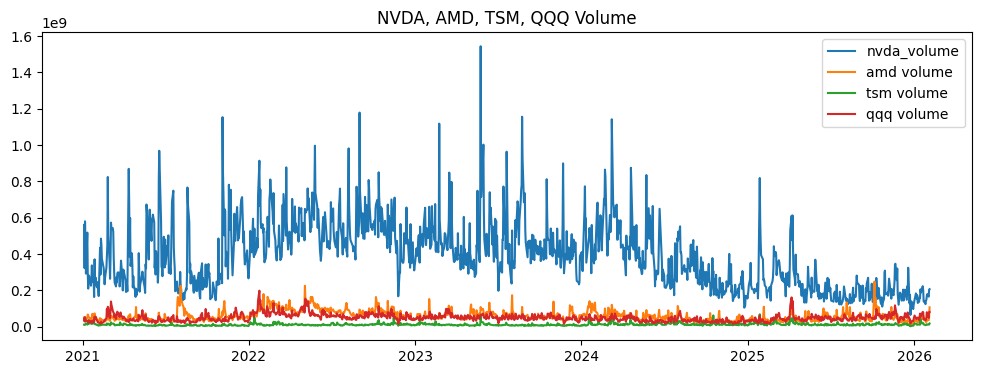

In [14]:
plt.figure(figsize=(12, 4))

plt.plot(nvda.index, nvda['nvda_close'], label='nvda close price')
plt.plot(amd.index, amd['amd_close'], label='amd close price')
plt.plot(tsm.index, tsm['tsm_close'], label='tsm close price')
plt.plot(qqq.index, qqq['qqq_close'], label='qqq close price')
plt.legend()
plt.title('NVDA, AMD, TSM, QQQ Closing Price')
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(nvda_volume.index, nvda_volume['nvda_volume'], label='nvda_volume')
plt.plot(amd_volume.index, amd_volume['amd_volume'], label='amd volume')
plt.plot(tsm_volume.index, tsm_volume['tsm_volume'], label='tsm volume')
plt.plot(qqq_volume.index, qqq_volume['qqq_volume'], label='qqq volume')
plt.legend()
plt.title('NVDA, AMD, TSM, QQQ Volume')
plt.show()


The closubg price chart indicates that all three stocks (NVDA, AMD, TSM, QQQ) have a non-stationary series. NVDA's closing price trend has minor incline but rose sharply starting from 2024. Even with minor drop in early 2025, the stock price seems to be going upward. These 4 stocks have very similar pattern. AMD fell below NVDA early 2025 but have since recovered and surpassed NVDA.

The volume chart shows nvda has the most volatility among the stocks stocks, with the most extreme spike happedn in the middle of 2023. NVDA volatility has reduced from 2025, but still by far the most volatie on the chart.

---
## Naive Baseline Model


In [15]:
# Test for one full year
# Split by the first business date in Feb 2025.
split_date = '2025-02-03'
horizons = [5, 10, 20, 30]

naive_results = []

# Loop thru different horizon window
for horizon in horizons:

    df_exp = df.copy()

    # True future price
    df_exp['y_true'] = df_exp['nvda_close'].shift(-horizon)

    # Naive prediction = today's price
    df_exp['y_pred'] = df_exp['nvda_close']

    df_exp = df_exp.dropna()

    train = df_exp.loc[:split_date]
    test  = df_exp.loc[split_date:]

    y_train = train['y_true']
    y_test  = test['y_true']

    y_pred_train = train['y_pred']
    y_pred_test  = test['y_pred']

    # Metrics
    mae_tr = mean_absolute_error(y_train, y_pred_train)
    rmse_tr = np.sqrt(mean_squared_error(y_train, y_pred_train))
    mape_tr = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100

    mae_te = mean_absolute_error(y_test, y_pred_test)
    rmse_te = np.sqrt(mean_squared_error(y_test, y_pred_test))
    mape_te = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

    naive_results.append({
        'Horizon': horizon,
        'Train_MAE': round(mae_tr, 2),
        'Test_MAE': round(mae_te, 2),
        'Train_RMSE': round(rmse_tr, 2),
        'Test_RMSE': round(rmse_te, 2),
        'Train_MAPE_%': round(mape_tr, 2),
        'Test_MAPE_%': round(mape_te, 2)
    })


In [16]:
naive_results_df = pd.DataFrame(naive_results)

print("Naive Baseline — Various Horizons")
display(naive_results_df)


Naive Baseline — Various Horizons


,Horizon,Train_MAE,Test_MAE,Train_RMSE,Test_RMSE,Train_MAPE_%,Test_MAPE_%
0,5,2.72,6.58,4.53,8.21,5.69,4.47
1,10,3.90,8.77,6.16,10.91,8.44,5.89
2,20,5.39,12.55,8.38,15.07,11.95,8.37
3,30,6.76,15.81,10.62,19.85,14.65,10.42


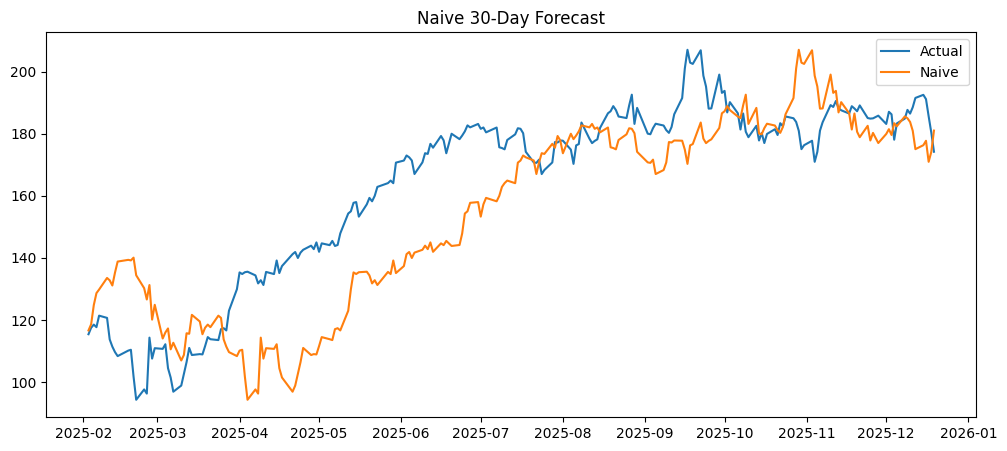

In [17]:
# Prediction 30 day window
h = 30

df_plot = df.copy()
df_plot['y_true'] = df_plot['nvda_close'].shift(-h)
df_plot['y_pred'] = df_plot['nvda_close']
df_plot = df_plot.dropna()

test_plot = df_plot[df_plot.index >= split_date]
plt.figure(figsize=(12,5))
plt.plot(test_plot.index, test_plot['y_true'], label='Actual')
plt.plot(test_plot.index, test_plot['y_pred'], label='Naive')
plt.title(f'Naive {h}-Day Forecast')
plt.legend()
plt.show()
